# WB - milestone 2 - inżynieria cech i wstępne modelowanie
## physioNet dataset
### Autorzy:
Paulina Jaszczuk \
Jędrzej Sokołowski \
Filip Szympliński

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import sklearn.metrics as metrics

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, r2_score, balanced_accuracy_score
import warnings
warnings.filterwarnings('ignore')


# ustawia domyślną wielkość wykresów
plt.rcParams['figure.figsize'] = (12,8)
# to samo tylko dla tekstu
plt.rcParams['font.size'] = 16

## Import danych i poglądowe informacje

Zbiór danych medycznych physioNet opisujący pacjentów z oddziałów kariochirurgicznych.

In [7]:
data = pd.read_csv("patients_data_ready.csv", sep=",", index_col=[0])
data.rename(columns = {"MechVent_max" : "MechVent"}, inplace = True)

Dane zawierają 5 cech statycznych (Age, Gender, Height, Weight, ICUType - rodzaj oddziału, na którym przebywał pacjent) oraz 75 cech dynamicznych, mierzonych co najmniej jednokrotnie. Wśród nich jest jedna zmienna binarna - MechVent - kolumna odpowiadająca informacji, czy pacjent został poddany wentylacji z użyciem respiratora. Zmienne dynamiczne, oprócz MechVent wyrażone są przez minimum, średnią i maximum z wszystkich pomiarów dla danego pacjenta. Zmienna celu - Survived - jest binarna (1, jeśli pacjent przeżył i 0, jeśli nie przeżył).

Nasze dane są mocno niezbalansowane - pacjentów, którzy zmarli jest zdecydawanie mniej niż tych, którzy przeżyli (stosunek mniej więcej 1:6). Jednocześnie to właśnie właściwa predykcja przypadków śmierci interesuje nas najbardziej. Między innymi z tego powodu zdecydowaliśmy się zastosować kilka metryk, a część z nich wyliczaliśmy oddzielnie dla obu klas - metryka ważona, z racji niezbalansowania klas, mogłaby być mocno zawyżona. Uznaliśmy, że główną metryką braną przez nas najbardziej pod uwagę podczas rozważania tego problemu jest recall. Dodatkowo rozpatrywaliśmy balanced accuracy score, precision, F1 score oraz Precision Recall Curve i AUPRC [(AUPRC link)](https://glassboxmedicine.com/2019/03/02/measuring-performance-auprc/).

W poprzednim etapie poddawaliśmy modelowaniu również ramkę danych z niektórymi zmiennymi zlogarytmowanymi, ale nie przyniosło to żadnych pozytywnych skutków, dlatego skupimy się na modelowaniu oryginalnego zbioru danych.

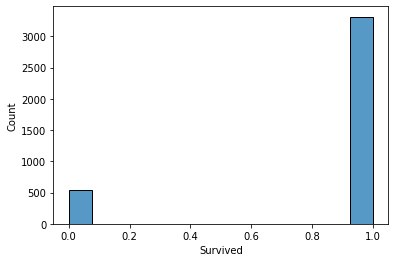

In [ ]:
#wykres niezbalansowania danych
sns.histplot( x = data['Survived'])
plt.show()

## Modelowanie i dobór hiperparametrów

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve, confusion_matrix, precision_score, recall_score

y = data["Survived"]
X = data.drop("Survived", axis= 1)

#podział zbioru na train/val/test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=420, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=420, test_size=0.125)

### Sztuczne zbalansowanie danych

Najpierw postanowiliśmy wypróbować SMOTE - Synthetic Minority Over-sampling Technique [(link do papera)](https://arxiv.org/abs/1106.1813). Jest to metoda pozwalająca na sztuczne zbalansowanie danych. Jak pisaliśmy wyżej - wśród naszych danych jest bardzo mało tych dotyczących pacjentów, którzy zmarli, przez co nasz model podczas nauki często "ignoruje" te informacje. Jednocześnie to na detekcji właśnie takich pacjentów najbardziej nam zależy, dlatego wykorzystaliśmy SMOTE (tworzy nowe instancje klasy mniejszościowej na podstawie istniejących) oraz wg sugestii autora artukułu RandomUnderSampler (ograniczający liczność klasy dominującej).

In [ ]:
!pip install imbalanced-learn

In [ ]:
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.9)

In [ ]:
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_sm, y_sm = pipeline.fit_resample(X_train, y_train)

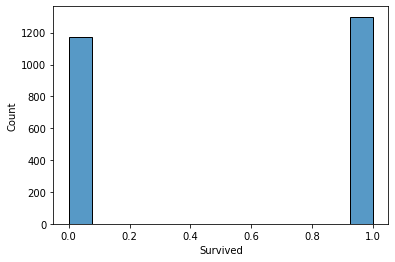

In [ ]:
sns.histplot(x = y_sm)
plt.show()

In [ ]:
#funkcja do printowania metryk
def show_model_metrics(model, X, y):
    y_pred = model.predict(X)
    print(f"balanced accuracy score: {balanced_accuracy_score(y, y_pred)}")
    print(f"F1 score: {f1_score(y, y_pred, average=None)}")
    print(f"F1 score micro: {f1_score(y, y_pred, average='micro')}")
    print(f"F1 score weighted: {f1_score(y, y_pred, average='weighted')}")
    print(f"Precision score: {precision_score(y, y_pred, average=None)}")
    print(f"Recall score: {recall_score(y, y_pred, average=None)}")

    precision, recall, thresholds = metrics.precision_recall_curve(y, y_pred, pos_label=0)
    print(f"AUPRC: {metrics.auc(recall, precision)}")

    plt.plot(recall, precision)
    plt.title("PRC plot for test data")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.rcParams["figure.figsize"] = (10,10)

    metrics.plot_confusion_matrix(model, X, y, display_labels=['Died', 'Survived'],
                                 cmap=plt.cm.Blues)


Na poprzednim etapie prac Random Forest i XGBoost okazały się najbardziej perspektywicznymi modelami, dlatego teraz będziemy rozważać właśnie je.

### Random Forest

#### Domyślne parametry

balanced accuracy score: 0.5408201354449955
F1 score: [0.15625    0.92372881]
F1 score micro: 0.8601036269430051
F1 score weighted: 0.8103964498990077
Precision score: [0.71428571 0.86279683]
Recall score: [0.0877193  0.99392097]
AUPRC: 0.5312186179284732


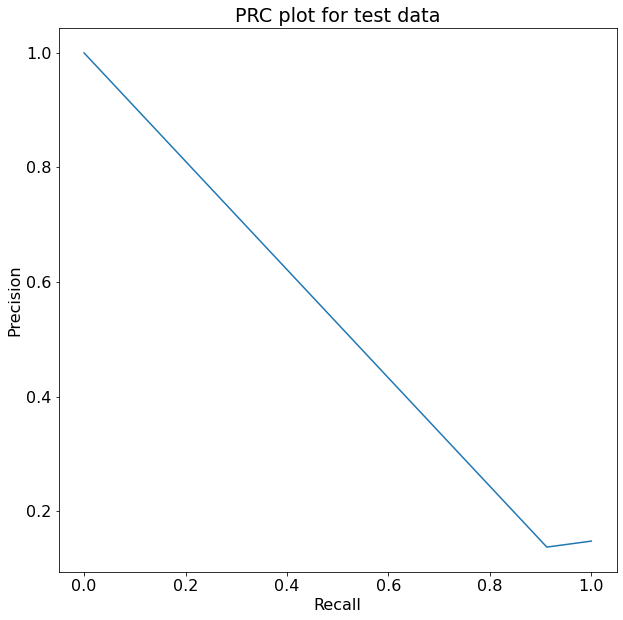

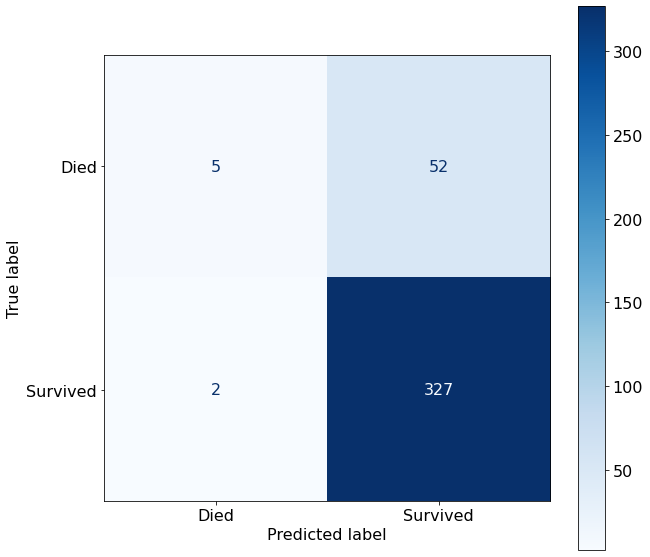

In [ ]:
#random forest na zbiorze oryginalnym
rForest = RandomForestClassifier()
rForest.fit(X_train, y_train)

y_pred = rForest.predict(X_val)
show_model_metrics(rForest, X_val, y_val)

balanced accuracy score: 0.6760518317069268
F1 score: [0.43548387 0.89197531]
F1 score micro: 0.8186528497409327
F1 score weighted: 0.8245659512652103
Precision score: [0.40298507 0.90595611]
Recall score: [0.47368421 0.87841945]
AUPRC: 0.34515393157475854


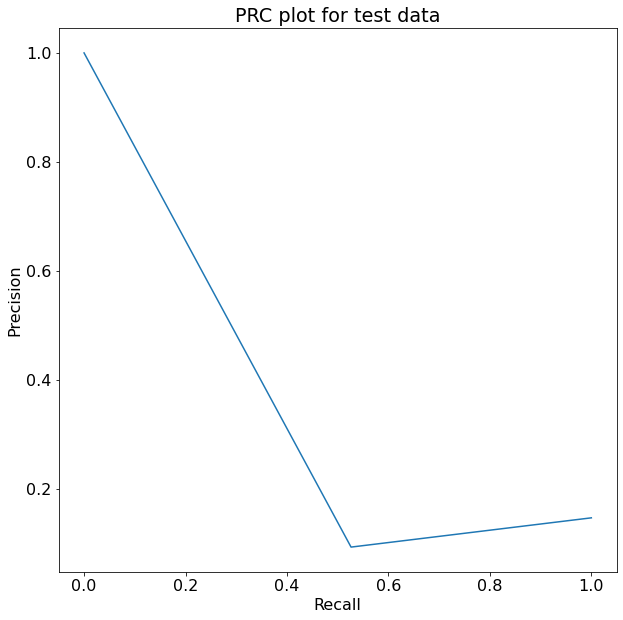

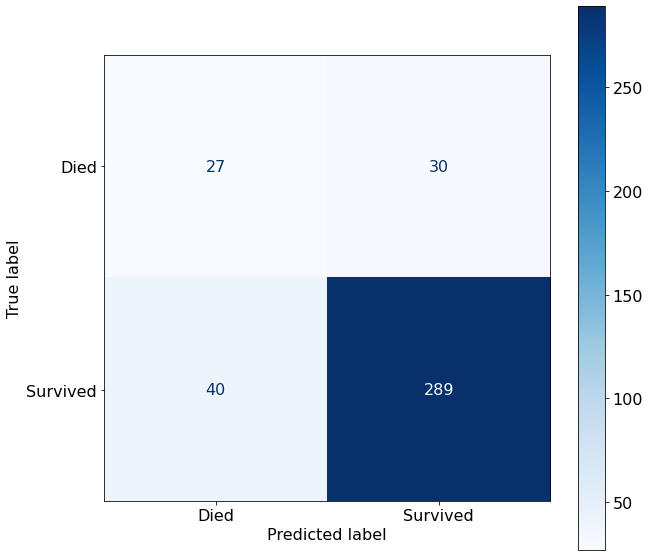

In [ ]:
#random forest na zbiorze zbalansowanym
rForest_sm = RandomForestClassifier()
rForest_sm.fit(X_sm, y_sm)

y_pred = rForest.predict(X_val)
show_model_metrics(rForest_sm, X_val, y_val)

Jak widać zbalansowanie klas znacząco poprawiło recall - przypadki śmiertelne są częściej wykrywane (trzeba też zaznaczyć, że też jest ich zwyczajnie więcej), jednak jednocześnie mocno spadło precision - zalednie połowa przypadków sklasyfikowanych jako śmiertelne rzeczywiście taka była.

Spróbujmy teraz dobrać optymalne parametry

#### `GridSearchCV`


In [ ]:
max_depth=[3, 4, 5]
n_estimators = [80, 90, 100, 110, 120]
criterion=["gini","entrophy"]
min_samples_split = [2, 5, 10, 20, 50]
param_grid = dict(max_depth=max_depth, n_estimators = n_estimators, criterion=criterion, min_samples_split=min_samples_split)

In [ ]:
from sklearn.model_selection import GridSearchCV

# na zbiorze oryginalnym
forest = RandomForestClassifier()
grid = GridSearchCV(estimator=forest, param_grid=param_grid, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.8754641654641656
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 5, 'n_estimators': 90} 


balanced accuracy score: 0.5087719298245614
F1 score: [0.03448276 0.92156863]
F1 score micro: 0.854922279792746
F1 score weighted: 0.7905740820537612
Precision score: [1.         0.85454545]
Recall score: [0.01754386 1.        ]
AUPRC: 0.5652506796902761


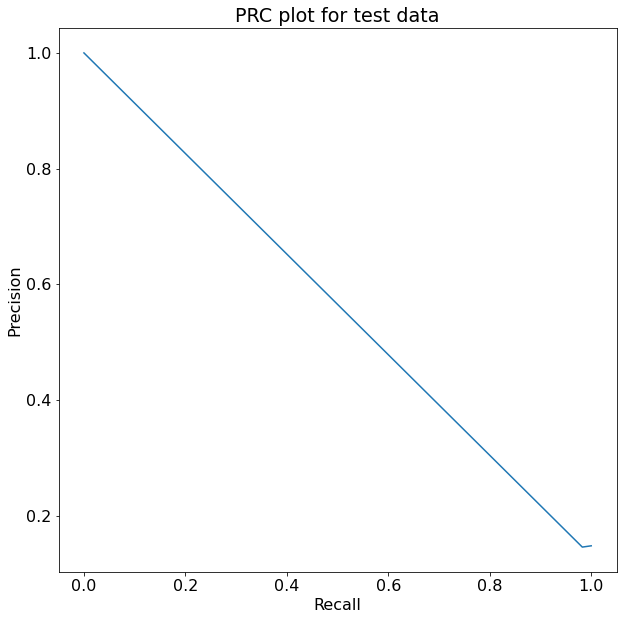

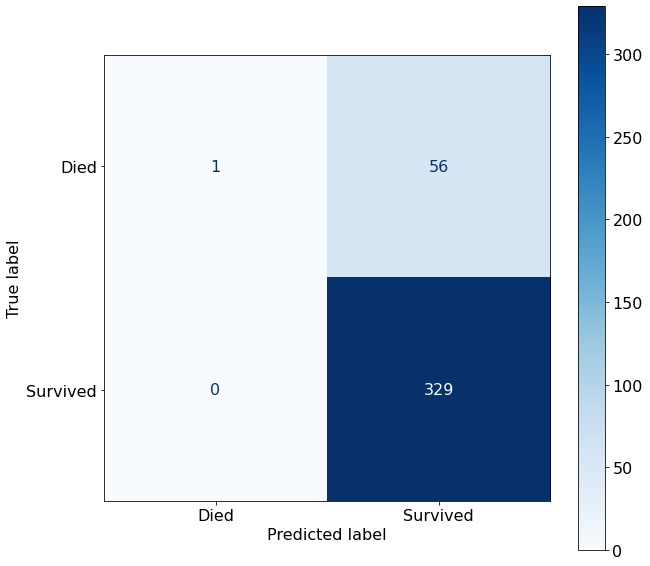

In [ ]:
# na zbiorze orginalnym
rForest_param = RandomForestClassifier(min_samples_split = 5,
                             criterion = 'gini',
                             max_depth = 5,
                             n_estimators = 90)

rForest_param.fit(X_train, y_train)
y_pred = rForest_param.predict(X_val)
show_model_metrics(rForest_param, X_val, y_val)

balanced accuracy score: 0.7134858422652376
F1 score: [0.47142857 0.88291139]
F1 score micro: 0.8082901554404145
F1 score weighted: 0.8221483851624206
Precision score: [0.39759036 0.92079208]
Recall score: [0.57894737 0.84802432]
AUPRC: 0.2928763901751506


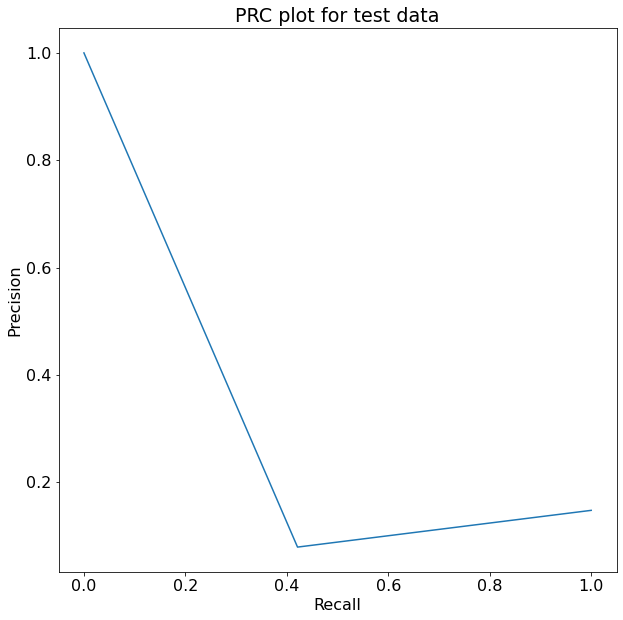

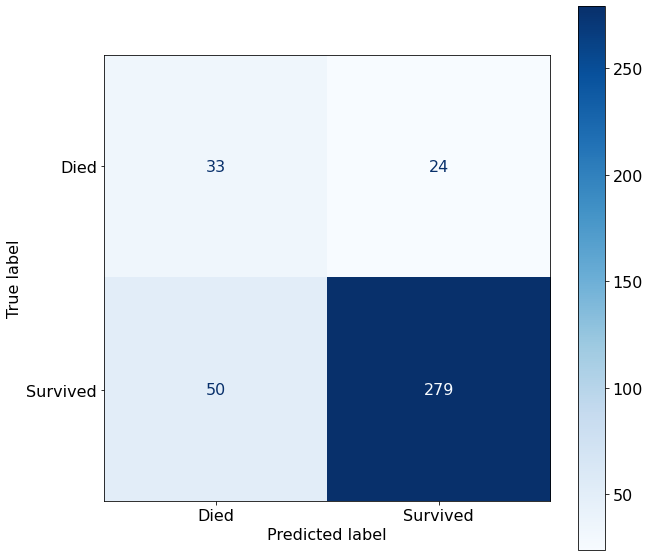

In [ ]:
# na zbiorze zbalansowanym
rForest_param_sm = RandomForestClassifier(min_samples_split = 5,
                             criterion = 'gini',
                             max_depth = 5,
                             n_estimators = 90)
rForest_param_sm.fit(X_sm, y_sm)
y_pred = rForest_param_sm.predict(X_val)
show_model_metrics(rForest_param_sm, X_val, y_val)

#### `RandomizedSearchCV`

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

forest = RandomForestClassifier()
random = RandomizedSearchCV(estimator=forest, param_distributions=param_grid, cv = 5, n_jobs=-1, random_state = 100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {random_result.best_score_}")
print(f"Best parameters: {random_result.best_params_}")

Best score: 0.8721267092695664
Best parameters: {'n_estimators': 80, 'min_samples_split': 50, 'max_depth': 4, 'criterion': 'gini'}


balanced accuracy score: 0.5087719298245614
F1 score: [0.03448276 0.92156863]
F1 score micro: 0.854922279792746
F1 score weighted: 0.7905740820537612
Precision score: [1.         0.85454545]
Recall score: [0.01754386 1.        ]
AUPRC: 0.5652506796902761


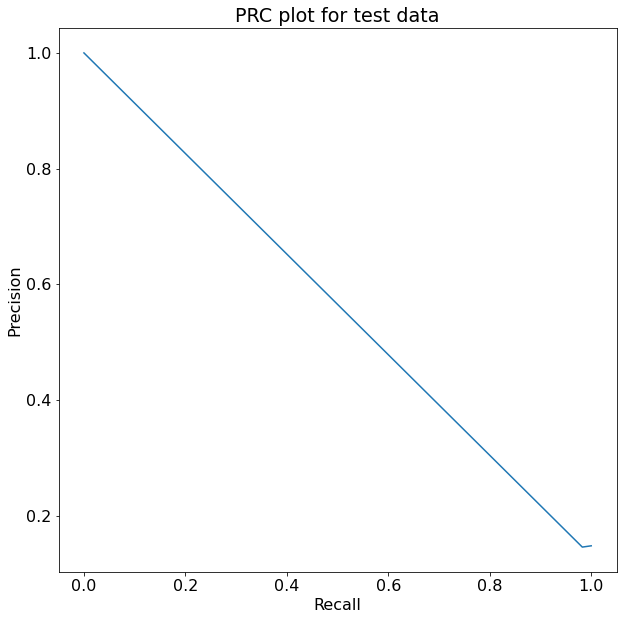

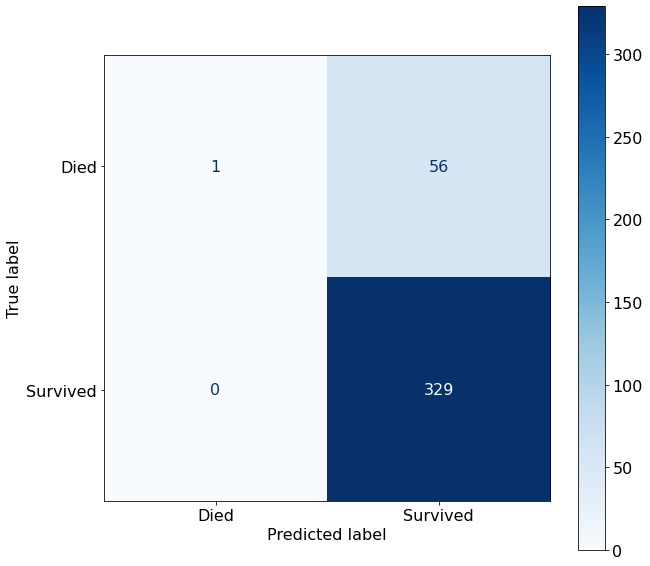

In [ ]:
# na zbiorze orginalnym
rForest_param2 = RandomForestClassifier(min_samples_split = 50,
                             criterion = 'gini',
                             max_depth = 4,
                             n_estimators = 80)

rForest_param2.fit(X_train, y_train)
y_pred = rForest_param2.predict(X_val)
show_model_metrics(rForest_param2, X_val, y_val)

balanced accuracy score: 0.7013277875539914
F1 score: [0.44594595 0.86858974]
F1 score micro: 0.7875647668393783
F1 score weighted: 0.8061786128495972
Precision score: [0.36263736 0.91864407]
Recall score: [0.57894737 0.82370821]
AUPRC: 0.2939503958808059


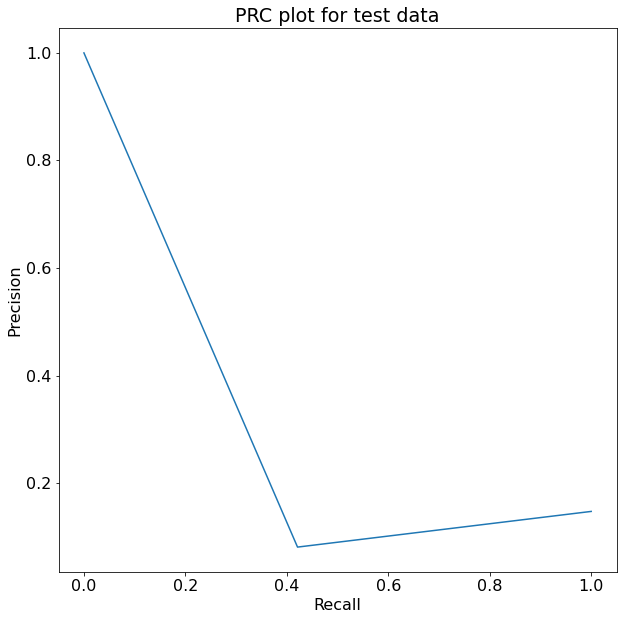

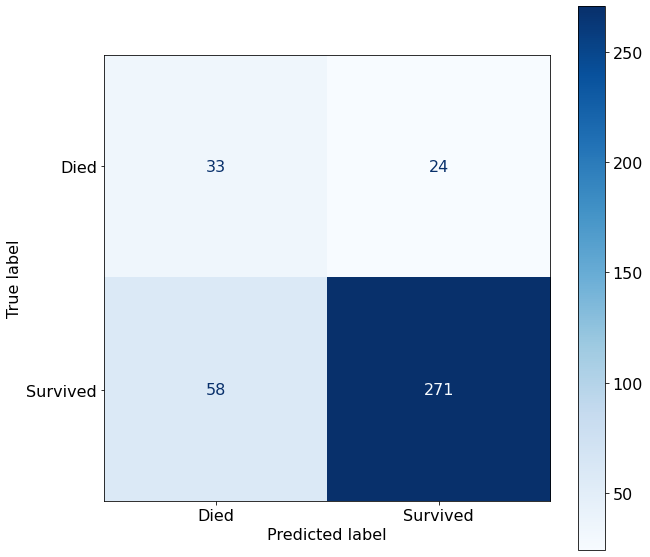

In [ ]:
# na zbiorze zbalansowanym
rForest_param2_sm = RandomForestClassifier(min_samples_split = 50,
                             criterion = 'gini',
                             max_depth = 4,
                             n_estimators = 80)
rForest_param2_sm.fit(X_sm, y_sm)
y_pred = rForest_param2_sm.predict(X_val)
show_model_metrics(rForest_param2_sm, X_val, y_val)

Zastosowanie `GridSearchCV` oraz  `RandomizedSearchCV` dla zbioru zbalansowanego dało podobne rezulaty, było to poprawienie precision, oraz lepszy recall dla pacjentów którzy zmarli lecz gorszy dla tych którzy przeżyli.

W przypadku orginalnego zbioru danych dobranie parametrów wpłynęło na poprawienie precision, ale nie skutkowało poprawieniem wyników recall.

### XGBoost

#### Domyślne parametry

balanced accuracy score: 0.6094758172025809
F1 score: [0.35616438 0.93276109]
F1 score micro: 0.8782383419689119
F1 score weighted: 0.8476159781710605
Precision score: [0.8125     0.88108108]
Recall score: [0.22807018 0.99088146]
AUPRC: 0.4622637499785032


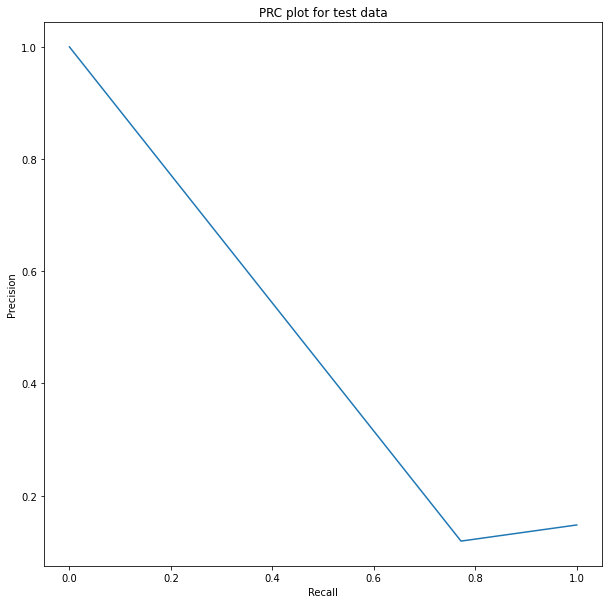

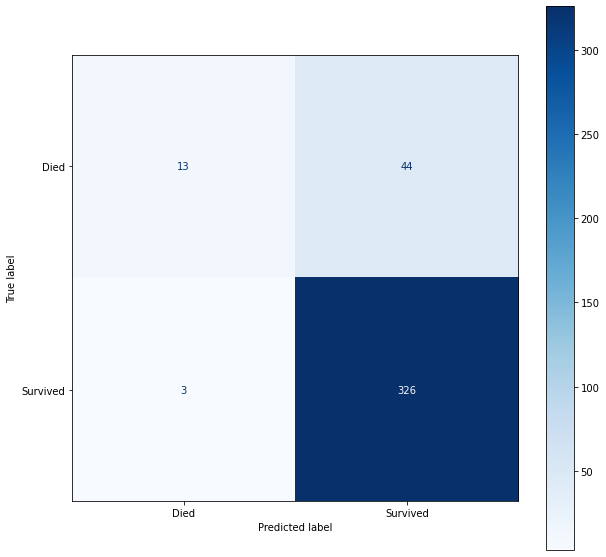

In [ ]:
# na zbiorze oryginalnym
xgb_clf = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
xgb_clf.fit(X_train, y_train)


y_pred = xgb_clf.predict(X_val)
show_model_metrics(xgb_clf, X_val, y_val)

balanced accuracy score: 0.6294992801151815
F1 score: [0.36842105 0.89057751]
F1 score micro: 0.8134715025906736
F1 score weighted: 0.8134715025906736
Precision score: [0.36842105 0.89057751]
Recall score: [0.36842105 0.89057751]
AUPRC: 0.3977027924236785


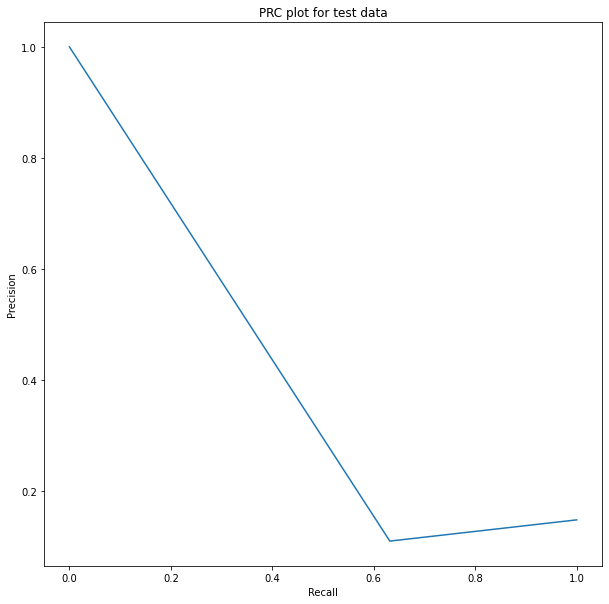

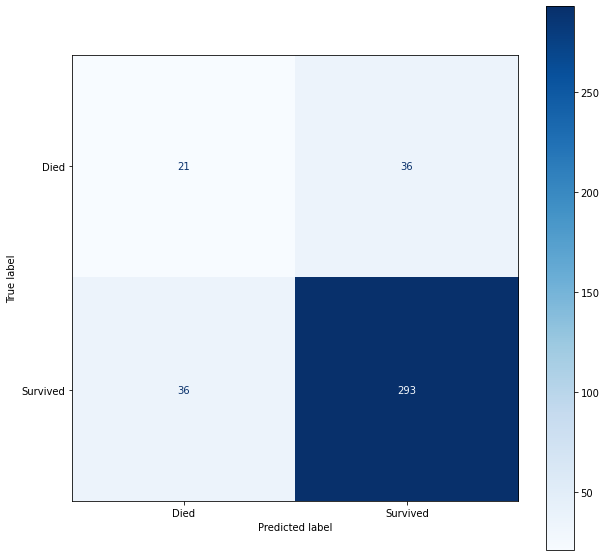

In [ ]:
# na zbiorze zbalansowanym
xgb_sm_clf = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
xgb_sm_clf.fit(X_sm, y_sm)


y_pred = xgb_sm_clf.predict(X_val)
show_model_metrics(xgb_sm_clf, X_val, y_val)

Podobnie jak w przypadku `Random Forest` dla zbioru zbalansowanego (wzgledem oryginalnego) lepiej wykrywamy śmiertelne przypadki pacjentów - wzrost recall dla zmarłych pacjentów z `0.22807018` do `0.36842105`. Niestety doprowadziło to do znacznego spadku precision z 0.8125 do 0.36842105. Pomimo takiej sytuacji, gdzie w wyniku wzrostu jednej metryki spada druga, możemy uznać taką sytucję za korzystną. Lepiej bowiem przewidzieć, że dany pacjen może umrzeć (mimo że przeżyje), ażeby była sytuacja odwrotna.

#### `GridSearchCV`

In [ ]:
learning_rate = [0.2, 0.3]
max_depth = [6, 10, 15]
gamma = [0.0, 0.2]

param_grid_xgb = dict(learning_rate=learning_rate,
                  max_depth=max_depth,
                  gamma=gamma)

In [ ]:
xgb_model = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.8758311001168144
Best parameters: {'gamma': 0.2, 'learning_rate': 0.3, 'max_depth': 10} 


In [ ]:
xgb_model = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
grid = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv = 5, n_jobs=-1)

grid_result = grid.fit(X_sm, y_sm)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.8793522267206477
Best parameters: {'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 10} 


Zbiór oryginalny

balanced accuracy score: 0.558017383885245
F1 score: [0.21917808 0.91845494]
F1 score micro: 0.8523316062176166
F1 score weighted: 0.8151938458670311
Precision score: [0.5        0.86756757]
Recall score: [0.14035088 0.97568389]
AUPRC: 0.5064034719202432


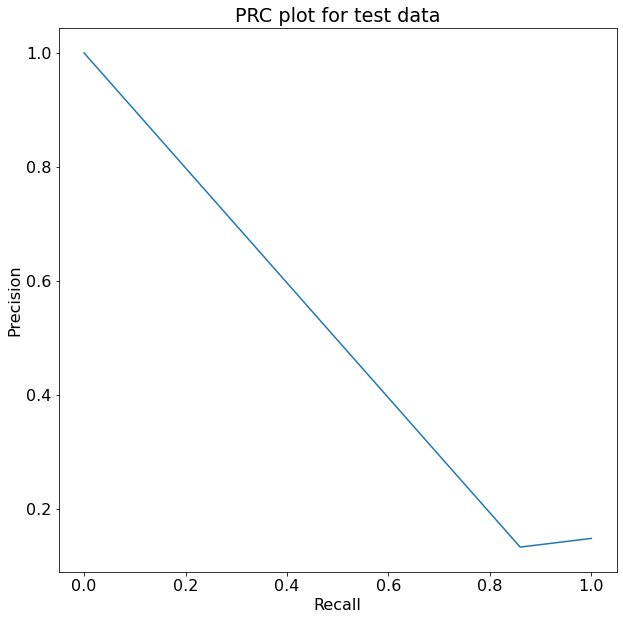

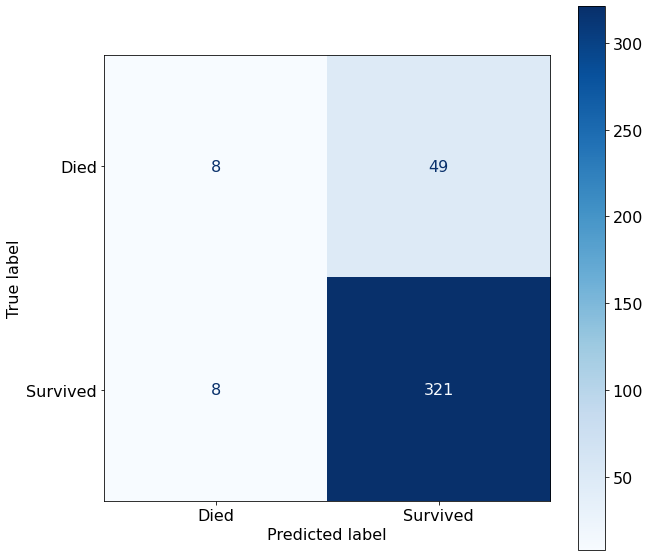

In [ ]:
# na zbiorze orginalnym
xgb_param_clf = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0,
                    learning_rate=0.3,
                    max_depth=10,
                    gamma=0.2
                    )
xgb_param_clf.fit(X_train, y_train)


y_pred = xgb_param_clf.predict(X_val)
show_model_metrics(xgb_param_clf, X_val, y_val)

Zbiór zbalansowany

balanced accuracy score: 0.6942889137737962
F1 score: [0.48214286 0.91212121]
F1 score micro: 0.8497409326424871
F1 score weighted: 0.8486269990803669
Precision score: [0.49090909 0.90936556]
Recall score: [0.47368421 0.91489362]
AUPRC: 0.3434492085448974


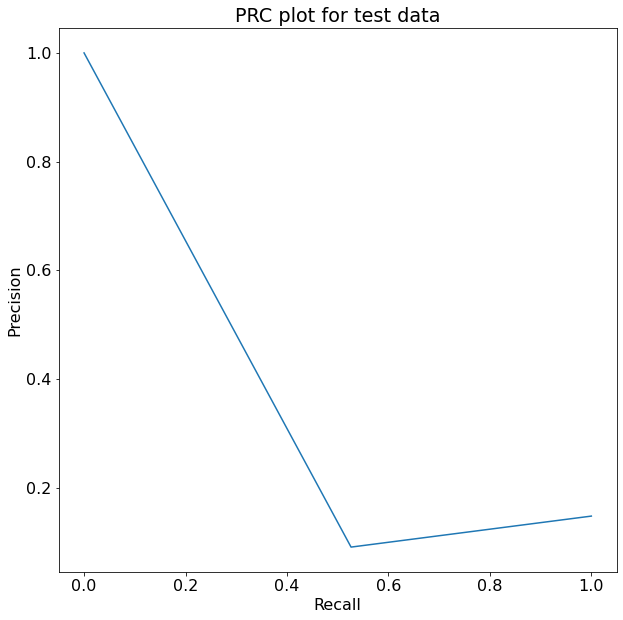

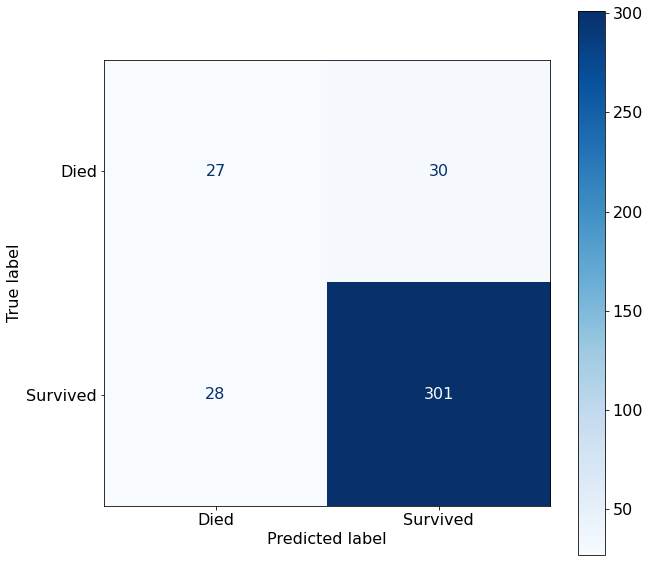

In [ ]:
# na zbiorze zbalansowanym
xgb_sm_param_clf = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0,
                    learning_rate=0.3,
                    max_depth=10,
                    gamma=0.2
                    )
xgb_sm_param_clf.fit(X_sm, y_sm)


y_pred = xgb_sm_param_clf.predict(X_val)
show_model_metrics(xgb_sm_param_clf, X_val, y_val)

#### `RandomizedSearchCV`

In [ ]:
xgb_model = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, cv = 5, n_jobs=-1, random_state=100)

random_result = random.fit(X_train, y_train)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.8793522267206477
Best parameters: {'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 10} 


In [ ]:
xgb_model = xgb.XGBClassifier(
                    booster='gbtree', 
                    use_label_encoder=False,
                    verbosity = 0
                    )
random = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, cv = 5, n_jobs=-1, random_state=100)

random_result = random.fit(X_sm, y_sm)

print(f"Best score: {grid_result.best_score_}")
print(f"Best parameters: {grid_result.best_params_} ")

Best score: 0.8793522267206477
Best parameters: {'gamma': 0.0, 'learning_rate': 0.3, 'max_depth': 10} 


Uzyskane parametry są takie same jak w przypadku `GridSearchCV`, więc i wyniki oraz wnioski będą takie same.

W wyniku dobierania hiperparametrów udało się polepszyć krytyczne metryki, co skutkuje lepszą wykrywalnością pacjentów, którzy zmarli.

Jak widać zbalansowanie klas znacząco poprawiło recall - przypadki śmiertelne są częściej wykrywane (trzeba też zaznaczyć, że jest ich zwyczajnie więcej), jednak jednocześnie mocno spadło precision - zaledwie połowa przypadków sklasyfikowanych jako śmiertelne rzeczywiście taka była.

### AutoML

#### TPOT

AutoML wyboru modeli [(link do papera)](https://dl.acm.org/doi/10.1145/2908812.2908918).


In [ ]:
!pip install tpot

In [ ]:
from tpot import TPOTClassifier

In [9]:
#NIE DOTYKAĆ!!1!!1! KRĘCI SIĘ PÓŁ DNIA
tpot = TPOTClassifier(generations=4,verbosity=2)

tpot.fit(X_train, y_train)

Optimization Progress:   0%|          | 0/500 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8787974987974987

Generation 2 - Current best internal CV score: 0.8802817288531575

Generation 3 - Current best internal CV score: 0.8802817288531575

Generation 4 - Current best internal CV score: 0.8802817288531575

Best pipeline: XGBClassifier(input_matrix, learning_rate=0.1, max_depth=2, min_child_weight=1, n_estimators=100, n_jobs=1, subsample=0.6500000000000001, verbosity=0)


TPOTClassifier(generations=4, verbosity=2)

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier(bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=7, 
                           min_samples_split=4, n_estimators=100)

In [ ]:
etc.fit(X_train, y_train)

In [ ]:
etc_metrics = show_model_metrics(etc, X, y)

Model ma bardzo dobre precision, natiomiast słabe recall. Być może jest tak dlatego, że TPOT w założeniu maksymalizuje Accuracy.

#### HyperOptEstimator

In [ ]:
!pip install hyperopt

In [ ]:
!pip install git+https://github.com/hyperopt/hyperopt-sklearn

In [ ]:
from hpsklearn import HyperoptEstimator
from hpsklearn import any_classifier
from hyperopt import tpe

In [ ]:
he = HyperoptEstimator(classifier=any_classifier('clf'), algo=tpe.suggest, max_evals=10, trial_timeout=60)
he.fit(X_train,y_train)

100%|██████████| 10/10 [00:00<00:00,  3.78trial/s, best loss: 0.12037037037037035]


In [ ]:
print(he.best_model())

{'learner': KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='euclidean',
                     n_jobs=1, n_neighbors=4, p=3.7420243016283297,
                     weights='distance'), 'preprocs': (StandardScaler(with_mean=False),), 'ex_preprocs': ()}


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knc = KNeighborsClassifier(algorithm='brute', leaf_size=35, metric='euclidean',
                     n_jobs=1, n_neighbors=4, p=3.7420243016283297,
                     weights='distance')

balanced accuracy score: 0.5359142537194048
F1 score: [0.16216216 0.91117479]
F1 score micro: 0.8393782383419688
F1 score weighted: 0.8005692941482837
Precision score: [0.35294118 0.86178862]
Recall score: [0.10526316 0.96656535]
AUPRC: 0.5242461328349307


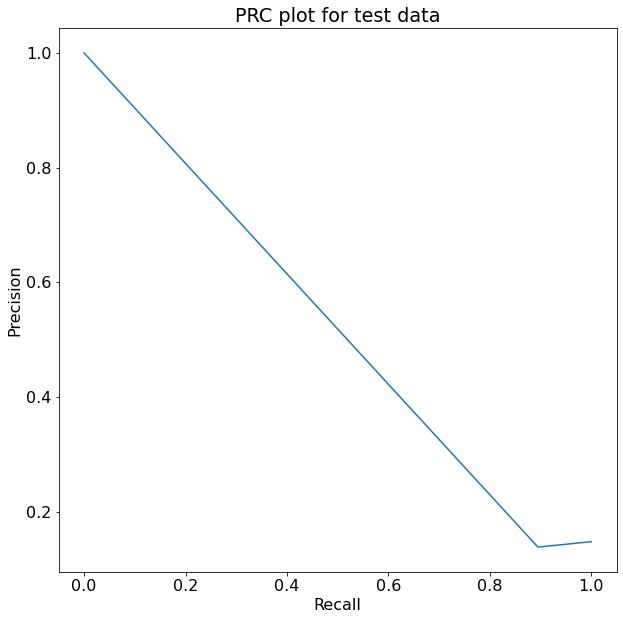

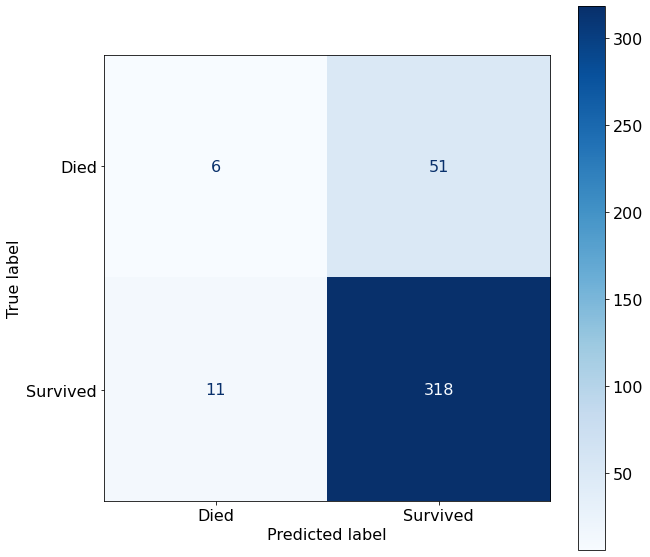

In [ ]:
knc.fit(X_train, y_train)
show_model_metrics(knc, X_val, y_val)

balanced accuracy score: 0.5536447501733056
F1 score: [0.2617801  0.75731497]
F1 score micro: 0.6347150259067358
F1 score weighted: 0.6841401359445868
Precision score: [0.18656716 0.87301587]
Recall score: [0.43859649 0.66869301]
AUPRC: 0.37657723756714756


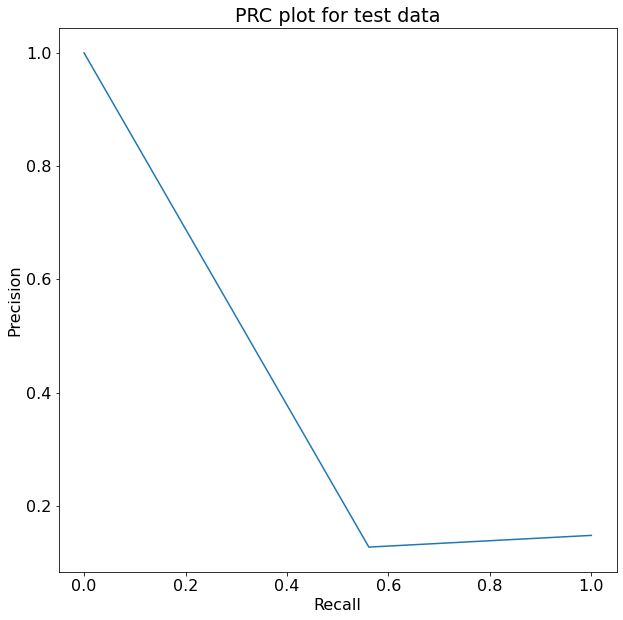

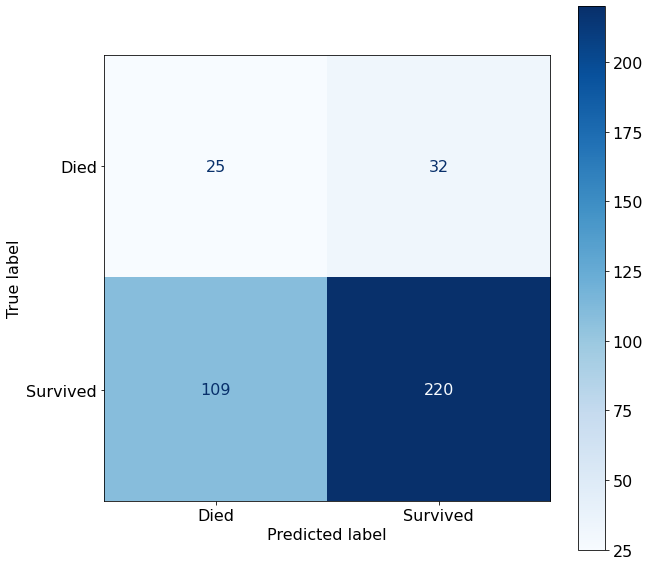

In [ ]:
knc.fit(X_sm, y_sm)
show_model_metrics(knc, X_val, y_val)

## Podsumowanie

Ze względu na charakter naszych danych, najbardziej interesującymi nas metrykami do oceny modeli były Recall i Precision.

Najlepsza wartość średniej dokładności modelu na przestrzeni obu przewydywanych klas wynosiła około 70%. Takie wyniki otrzymały modele `RandomForest` oraz `XGBoost` będące po doborze optymalnych parametrów oraz wytrenowane na zbalansowanym zbiorze danych.

W wielu przypadkach, zastosowanie zbalansowanego zbioru danych, wpływało na znaczne poprawienie wartości recall dla pacjentów którzy zmarli, lecz niosło ze sobą równiez pogorszenie dla pozostałych pacjentów oraz ogólnie słabsze wyniki metryki precision. Tak czy inaczej, średnia dokładność była w tych sytuacjach lepsza.

Biorąc pod uwagę, że wykrywanie przypadków śmiertelnych interesuje nas najbardziej, można stwierdzić, że zbalansowanie danych miało istotny wpływ na działanie modelu.